# Master video notebook!
This title might be a bit ambitious, but this notebook is supposed to be able to do all of the administration work when it comes to downloading, processing and analysing videos. The most important functions that will be called are stored in other python files, such that this notebook will remain legible. Analysis will be able to be done with a hierarchy structure of dataset, plate, video, hypha.

### In MODULE one,
the Dropbox is scoured for information about videos. If the videos do not have a VideoInfo.txt, the program will look for a .csv, if there is no .csv, the program will look for a .xlsx file. Once these files have been found, all information will be merged into a pandas dataframe, and saved as a json file for the dataset and for each video. Some datasets contain thousands of videos, so scouring the dropbox for info on all of them is going to be an hours-long affair. Plan your analysis accordingly.

After scouring is complete, a final filtering step can be taken, whereupon the whole list of videos can be downloaded. NB: Downloading happens in two ways: videos are downloaded to the specified analysis folder, whereas video parameters and analysis will be downloaded to the specified analysis folder. This separation is done such that videos can be stored on larger storage drives, and analysis folders on faster storage drives.

(if Snellius is still used, it is recommended to use your scratch storage to store videos, and your home storage to store analysis. Scratch storage gets wiped every two weeks, but is much larger than home storage. )

TODO: Give options to download with SLURM job or manually.

### In MODULE two,
the downloaded videos with their respective information can be filtered, then analysed with a large SLURM job. In the future there might need to be functionality that allows processing without the use of a SLURM job. If you're reading this in 2024, you better apply for another Snellius grant!

### In MODULE three,
This is where all the bulk analysis is going to be. In high_mag_analysis.py, there are a number of classes and functions that will help you with parsing the data into meaningful graphs. This MODULE assumes the existence of the video_info.json files that are generated partly in MODULE 1.

### Below code:
Are just import statements

In [57]:
from IPython.display import clear_output
import re
from amftrack.pipeline.development.high_mag_videos.plot_data import (
    plot_summary,
    save_raw_data,
)
from amftrack.pipeline.development.high_mag_videos.high_mag_analysis import (
    HighmagDataset,
    VideoDataset,
    EdgeDataset,
    index_videos_dropbox,
    analysis_run,
)
from amftrack.pipeline.development.high_mag_videos.kymo_class import (
    KymoVideoAnalysis,
    KymoEdgeAnalysis
)
import sys
import os
import pandas as pd
import numpy as np
import imageio.v2 as imageio
import matplotlib.pyplot as plt
import cv2
from tifffile import imwrite
from tqdm import tqdm
import scipy
import matplotlib as mpl
from pathlib import Path
from amftrack.pipeline.launching.run import (
    run_transfer,
)
from amftrack.pipeline.launching.run_super import run_parallel_transfer
import dropbox
from amftrack.util.dbx import upload_folder, download, read_saved_dropbox_state, save_dropbox_state, load_dbx, get_dropbox_folders, get_dropbox_video_folders, download_video_folders_drop, download_analysis_folders_drop
from subprocess import call
import logging
import datetime
import glob
import json
from amftrack.pipeline.launching.run_super import run_parallel_flows

%matplotlib widget
%load_ext autoreload
%autoreload 2
logging.basicConfig(stream=sys.stdout, level=logging.debug)
mpl.rcParams['figure.dpi'] = 300


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## File declaration
As this notebook is designed to work with Snellius (now also on a local computer!), two items to separate are the raw video files and the analysis. The raw video files are large, bulky and not so easy to flip through. Ideally, the video files would be downloaded and the analysis would be stored on a separate folder structure entirely. That way, large scale analysis of analysis folders can happen when there are thousands of videos in the dataset, without having to have those raw video folders on hand.

Below function will basically make your folders fertile ground to accept all the video info folders and raw video files.

### Input:
Please give separately the folder where raw video data is stored, and where the analysis will be stored. Also give the dropbox address of the dataset you want to analyze.

### Output:
The specified dropbox folder will be looked through, and all relevant video information will be downloaded to an analysis folder structure identical to what is present on teh dropbox. The relevant raw video folder structure will also be generated, if specified so. Will also create cache files in the form of .json files such that next time, the scrounging does not have to happen.

In [69]:
videos_folder = "E:\\AMOLF_Data\\AMOLF-SHIMIZU Dropbox\\DATA\\"
analysis_folder = "E:\\AMOLF_Data\\analysis\\"

# videos_folder = "/gpfs/scratch1/shared/amftrackflow/videos/"
# analysis_folder = "/gpfs/home6/svstaalduine/Analysis/"

In [59]:
# dropbox_address = "/DATA/FLUORESCENCE/DATA_NileRed/"
# dropbox_address=  "/DATA/MYRISTATE/DATA/"
# dropbox_address = "/DATA/TransportROOT/"
dropbox_address = "/DATA/CocoTransport/"
# dropbox_address = "/DATA/TRANSPORT/DATA/20230721_Plate301/"

In [60]:
video_param_frame = index_videos_dropbox(analysis_folder, videos_folder, dropbox_address, REDO_SCROUNGING=False)
video_param_frame

All files downloaded! Merging files...


100%|██████████| 11/11 [00:00<00:00, 35.37it/s]


,imaging_day,storage_path,plate_id,root,strain,treatment,crossing_day,video_int,time_(s),mode,...,ypos,zpos,unique_id,folder,tot_path_drop,record_time,days_after_crossing,magnification,analysis_folder,videos_folder
0,20230703,Dropbox\DATA\CocoTransport,20230703_Plate403,Carrot,C2,001P100N100C,20230626,1,30.0,BF,...,0.320,5.993,20230703_Plate403_001,CocoTransport/20230703_Plate403/001/Img,DATA/CocoTransport/20230703_Plate403/001/Img,16:45:29,7,50.0,NaN,NaN
1,20230713,Dropbox\DATA\CocoTransport,20230713_Plate13,Carrot,O9,001P100N100C,20230713,1,60.0,BF,...,10.705,5.900,20230713_Plate013_001,CocoTransport/20230713_Plate013/001/Img,DATA/CocoTransport/20230713_Plate013/001/Img,12:07:45,0,50.0,NaN,NaN
2,20230714,Dropbox\DATA\CocoTransport,20230714_Plate302,Carrot,A5,001P100N100C,20230714,2,30.0,BF,...,17.800,5.567,20230714_Plate302_002,CocoTransport/20230714_Plate302/002/Img,DATA/CocoTransport/20230714_Plate302/002/Img,11:50:33,0,50.0,NaN,NaN
3,20230714,Dropbox\DATA\CocoTransport,20230714_Plate302,Carrot,A5,001P100N100C,20230714,3,30.0,BF,...,17.207,5.568,20230714_Plate302_003,CocoTransport/20230714_Plate302/003/Img,DATA/CocoTransport/20230714_Plate302/003/Img,11:51:33,0,50.0,NaN,NaN
4,20230714,Dropbox\DATA\CocoTransport,20230714_Plate302,Carrot,A5,001P100N100C,20230714,4,30.0,BF,...,16.904,5.589,20230714_Plate302_004,CocoTransport/20230714_Plate302/004/Img,DATA/CocoTransport/20230714_Plate302/004/Img,11:52:38,0,50.0,NaN,NaN
5,20230714,Dropbox\DATA\CocoTransport,20230714_Plate302,Carrot,A5,001P100N100C,20230714,5,30.0,BF,...,16.433,5.621,20230714_Plate302_005,CocoTransport/20230714_Plate302/005/Img,DATA/CocoTransport/20230714_Plate302/005/Img,11:53:37,0,50.0,NaN,NaN
6,20230714,Dropbox\DATA\CocoTransport,20230714_Plate302,Carrot,A5,001P100N100C,20230714,6,30.0,BF,...,15.750,5.685,20230714_Plate302_006,CocoTransport/20230714_Plate302/006/Img,DATA/CocoTransport/20230714_Plate302/006/Img,11:54:38,0,50.0,NaN,NaN
7,20230714,Dropbox\DATA\CocoTransport,20230714_Plate302,Carrot,A5,001P100N100C,20230714,7,30.0,BF,...,15.109,5.750,20230714_Plate302_007,CocoTransport/20230714_Plate302/007/Img,DATA/CocoTransport/20230714_Plate302/007/Img,11:55:48,0,50.0,NaN,NaN
8,20230714,Dropbox\DATA\CocoTransport,20230714_Plate302,Carrot,A5,001P100N100C,20230714,9,30.0,BF,...,14.466,5.813,20230714_Plate302_009,CocoTransport/20230714_Plate302/009/Img,DATA/CocoTransport/20230714_Plate302/009/Img,11:58:22,0,50.0,NaN,NaN
9,20230714,Dropbox\DATA\CocoTransport,20230714_Plate302,Carrot,A5,001P100N100C,20230714,10,30.0,BF,...,14.169,5.825,20230714_Plate302_010,CocoTransport/20230714_Plate302/010/Img,DATA/CocoTransport/20230714_Plate302/010/Img,11:59:39,0,50.0,NaN,NaN


## Where to go?
If you want to download videos:
Use MODULE 1

If you want to analyze already downloaded videos:
Skip MODULE 1, use MODULE 2

# MODULE 1: Downloading
This section, there is one block of code that will ask you one last time whether all of the parameters are correct. The block of code after that will initiate Snellius jobs to download the videos in the DataFrame from the dropbox. Downloading videos is not that costly, but of course we prefer it to be done as efficiently as possible.
## I'm not on Snellius! How do i download stuff??
Easy. Just skip the second block of code. The one below will just use the dropbox API to properly download all your raw data.
WARNING: This process can be quite long if you are queueing up a lot of videos. Do not use that block of code on Snellius, they will get mad at you (and prematurely stop your running program), just use the SLURM job in that case.

### Input:
Nothing
### Output:
Print statement with the DataFrame and the folders where everything will be stored.
Subsequent block of code will download raw video files to the videos folder.

In [55]:
#####################################################################################
### This is where you can apply the filters. Only those videos will be downloaded ###
#####################################################################################

download_frame = video_param_frame[video_param_frame['imaging_day'].le("20230729")].iloc[0:1]

#####################################################################################
### Below code will prepare for those videos to be downloaded into videos_folder  ###
#####################################################################################
print(f"Number of videos that will be downloaded: {len(download_frame)}")
download_frame.head(5)

Number of videos that will be downloaded: 1


,imaging_day,storage_path,plate_id,root,strain,treatment,crossing_day,video_int,time_(s),mode,...,ypos,zpos,unique_id,folder,tot_path_drop,record_time,days_after_crossing,magnification,analysis_folder,videos_folder
0,20230718,Dropbox\DATA\CocoTransport,20230718_Plate431,Carrot,C2,001P100N100C,20230627,1,30.0,BF,...,15.411,7.354,20230718_Plate431_001,CocoTransport/20230718_Plate431/001/Img,DATA/CocoTransport/20230718_Plate431/001/Img,16:21:51,21,4.0,NaN,NaN


In [7]:
run_parallel_transfer(
    "from_drop_video.py",
    [videos_folder],
    download_frame,
    1,
    "10:00:00",
    "transfer_test"
)
clear_output(wait=False)

print("Sent all the jobs! Use the command '$ squeue' in the terminal to see the progress")

Sent all the jobs! Use the command '$ squeue' in the terminal to see the progress


### Download videos from Dropbox (Not a SLURM job)
This block of code can be used to download videos individually from dropbox. 
Be aware:
- This is significantly slower than launching a SLURM job
- This downloads videos sequentially, not in parallel
- If this function is running for too long on Snellius, it might get you booted from the interactive node
- Videos are large. Make sure you have the space.

In [56]:
download_video_folders_drop(download_frame, videos_folder)
clear_output(wait=False)
print("All videos downloaded!")

2023-07-30 17:49:19,573-[INFO]- dropbox:390 -> Refreshing access token.
2023-07-30 17:49:20,020-[INFO]- dropbox:474 -> Request to files/list_folder
2023-07-30 17:49:20,527-[INFO]- dropbox:474 -> Request to files/list_folder/continue
2023-07-30 17:49:21,647-[INFO]- dropbox:474 -> Request to files/list_folder/continue
2023-07-30 17:49:22,414-[INFO]- dropbox:474 -> Request to files/list_folder/continue
/DATA/CocoTransport/20230718_Plate431/001/Img/Img_00001.tif E:\AMOLF_Data\videos\CocoTransport\20230718_Plate431\001\Img\Img_00001.tif
2023-07-30 17:49:22,834-[INFO]- dropbox:390 -> Refreshing access token.
2023-07-30 17:49:23,180-[INFO]- dropbox:474 -> Request to files/download
/DATA/CocoTransport/20230718_Plate431/001/Img/Img_00007.tif E:\AMOLF_Data\videos\CocoTransport\20230718_Plate431\001\Img\Img_00007.tif
2023-07-30 17:49:28,613-[INFO]- dropbox:390 -> Refreshing access token.
2023-07-30 17:49:28,920-[INFO]- dropbox:474 -> Request to files/download
/DATA/CocoTransport/20230718_Plate431

KeyboardInterrupt: 

### Download Analysis folders from Dropbox (not a SLURM job)
Similar warnings apply as the video download function above. The file sizes for the analysis folders are, however, vastly smaller than video files. This allows for a bit more wiggle room.

In [ ]:
download_analysis_folders_drop(analysis_folder, dropbox_address)
clear_output(wait=False)
print("All analysis folders downloaded!")

# Module 2: Analysis
Now that the files have been downloaded, it's time to analyse them. In the below code, you'll be able to either do a complete survey of the analysis folder for as many videos as possible, or use the DataFrame of recently downloaded videos to filter for the videos you want to analyse.

Also possible to analyse videos directly in this notebook. Be aware again that this is a sequential, and slower analysis than running a SLURM job. 

### Input:
DataFrame filters of all videos to be analysed
### Output:
Print statements for all parameters of the analysis session that is about to take place.

In [70]:
print(dropbox_address)

/DATA/CocoTransport/


In [71]:
folder_filter = dropbox_address[5:]

img_infos = glob.glob(f"{analysis_folder}{folder_filter}/**/video_data.json", recursive=True)
vid_anls_frame = pd.DataFrame()
for address in img_infos:
    add_info = pd.read_json(address, orient='index').T
    vid_anls_frame = pd.concat([vid_anls_frame, add_info], ignore_index=True)

vid_anls_frame = vid_anls_frame.sort_values('unique_id').reset_index(drop=True)
vid_anls_frame

,imaging_day,storage_path,plate_id,root,strain,treatment,crossing_day,video_int,time_(s),mode,...,ypos,zpos,unique_id,folder,tot_path_drop,record_time,days_after_crossing,magnification,analysis_folder,videos_folder
0,20230703,Dropbox\DATA\CocoTransport,20230703_Plate403,Carrot,C2,001P100N100C,20230626,1,30.0,BF,...,0.32,5.993,20230703_Plate403_001,CocoTransport/20230703_Plate403/001/Img,DATA/CocoTransport/20230703_Plate403/001/Img,16:45:29,7,50.0,E:/AMOLF_Data/analysis/CocoTransport/20230703_...,E:/AMOLF_Data/videos/CocoTransport/20230703_Pl...
1,20230713,Dropbox\DATA\CocoTransport,20230713_Plate13,Carrot,O9,001P100N100C,20230713,1,60.0,BF,...,10.705,5.9,20230713_Plate013_001,CocoTransport/20230713_Plate013/001/Img,DATA/CocoTransport/20230713_Plate013/001/Img,12:07:45,0,50.0,E:/AMOLF_Data/analysis/CocoTransport/20230713_...,E:/AMOLF_Data/videos/CocoTransport/20230713_Pl...
2,20230714,Dropbox\DATA\CocoTransport,20230714_Plate302,Carrot,A5,001P100N100C,20230714,2,30.0,BF,...,17.8,5.567,20230714_Plate302_002,CocoTransport/20230714_Plate302/002/Img,DATA/CocoTransport/20230714_Plate302/002/Img,11:50:33,0,50.0,E:/AMOLF_Data/analysis/CocoTransport/20230714_...,E:/AMOLF_Data/videos/CocoTransport/20230714_Pl...
3,20230714,Dropbox\DATA\CocoTransport,20230714_Plate302,Carrot,A5,001P100N100C,20230714,3,30.0,BF,...,17.207,5.568,20230714_Plate302_003,CocoTransport/20230714_Plate302/003/Img,DATA/CocoTransport/20230714_Plate302/003/Img,11:51:33,0,50.0,E:/AMOLF_Data/analysis/CocoTransport/20230714_...,E:/AMOLF_Data/videos/CocoTransport/20230714_Pl...
4,20230714,Dropbox\DATA\CocoTransport,20230714_Plate302,Carrot,A5,001P100N100C,20230714,4,30.0,BF,...,16.904,5.589,20230714_Plate302_004,CocoTransport/20230714_Plate302/004/Img,DATA/CocoTransport/20230714_Plate302/004/Img,11:52:38,0,50.0,E:/AMOLF_Data/analysis/CocoTransport/20230714_...,E:/AMOLF_Data/videos/CocoTransport/20230714_Pl...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58,20230718,Dropbox\DATA\CocoTransport,20230718_Plate431,Carrot,C2,001P100N100C,20230627,53,300.0,BF,...,15.575,6.19,20230718_Plate431_053,CocoTransport/20230718_Plate431/053/Img,DATA/CocoTransport/20230718_Plate431/053/Img,18:23:50,21,50.0,E:/AMOLF_Data/analysis/CocoTransport/20230718_...,E:/AMOLF_Data/videos/CocoTransport/20230718_Pl...
59,20230718,Dropbox\DATA\CocoTransport,20230718_Plate431,Carrot,C2,001P100N100C,20230627,54,300.0,BF,...,15.575,6.199,20230718_Plate431_054,CocoTransport/20230718_Plate431/054/Img,DATA/CocoTransport/20230718_Plate431/054/Img,18:29:17,21,50.0,E:/AMOLF_Data/analysis/CocoTransport/20230718_...,E:/AMOLF_Data/videos/CocoTransport/20230718_Pl...
60,20230718,Dropbox\DATA\CocoTransport,20230718_Plate431,Carrot,C2,001P100N100C,20230627,55,300.0,BF,...,15.296,6.356,20230718_Plate431_055,CocoTransport/20230718_Plate431/055/Img,DATA/CocoTransport/20230718_Plate431/055/Img,18:38:14,21,50.0,E:/AMOLF_Data/analysis/CocoTransport/20230718_...,E:/AMOLF_Data/videos/CocoTransport/20230718_Pl...
61,20230718,Dropbox\DATA\CocoTransport,20230718_Plate431,Carrot,C2,001P100N100C,20230627,56,300.0,BF,...,15.296,6.356,20230718_Plate431_056,CocoTransport/20230718_Plate431/056/Img,DATA/CocoTransport/20230718_Plate431/056/Img,18:43:40,21,50.0,E:/AMOLF_Data/analysis/CocoTransport/20230718_...,E:/AMOLF_Data/videos/CocoTransport/20230718_Pl...


In [72]:
print(vid_anls_frame['analysis_folder'][0])

E:/AMOLF_Data/analysis/CocoTransport/20230703_Plate403/001


In [73]:
####################################################################################
### This is where you can apply the filters. Only those videos will be analyzed. ###
####################################################################################

analysis_frame = vid_anls_frame[vid_anls_frame['unique_id']=="20230714_Plate302_003"]

####################################################################################
### Below code will prepare for those videos to be downloaded to videos_folder.  ###
####################################################################################

print(f"Number of videos to be analyzed: {len(analysis_frame)}")
analysis_frame.head(5)

Number of videos to be analyzed: 1


,imaging_day,storage_path,plate_id,root,strain,treatment,crossing_day,video_int,time_(s),mode,...,ypos,zpos,unique_id,folder,tot_path_drop,record_time,days_after_crossing,magnification,analysis_folder,videos_folder
3,20230714,Dropbox\DATA\CocoTransport,20230714_Plate302,Carrot,A5,001P100N100C,20230714,3,30.0,BF,...,17.207,5.568,20230714_Plate302_003,CocoTransport/20230714_Plate302/003/Img,DATA/CocoTransport/20230714_Plate302/003/Img,11:51:33,0,50.0,E:/AMOLF_Data/analysis/CocoTransport/20230714_...,E:/AMOLF_Data/videos/CocoTransport/20230714_Pl...


## Run SLURM Analysis job
Two options: For small analysis, use the first block. This will just do the calculations on the machine. For large-scale analysis, use the second block, as it will create a Snellius job.
## Input:
Snellius job parameters
## Output:
Analysis folder will be populated with analysis tiffs and csv sheets. At the same time, this analysis folder will also be uploaded to the dropbox.

In [10]:
### LARGE VIDEO ANALYSIS

nr_parallel = np.min([len(analysis_frame.index), 4])

run_parallel_flows(
    "flux_extract.py",
    [analysis_folder, 9, 0.95, 0.005, 80, dropbox_address],
    analysis_frame,
    nr_parallel,
    "2:00:00",
    "flux_extract"
)
clear_output(wait=False)

print("Sent all the jobs! Use the command '$ squeue' in the terminal to see the progress")

Sent all the jobs! Use the command '$ squeue' in the terminal to see the progress


## Run local analysis
First the analysis function is defined, which you can change to fit the parameters you want. Then the next block of code will use that function to go through each row in the video analyis dataframe and executes the analysis. NOTE: This is not code to go through the analysis, that is for MODULE 3.


Data input succesful! Starting edge extraction...
Successfully extracted the skeleton. Did you know there is a skeleton inside inside you right now?
Working on edge (19, 6), sir!
Working on edge (23, 20), sir!
To work with individual edges of 20230703_Plate403_001, here is a list of their indices:
edge 0, (19, 6)
edge 1, (23, 20)


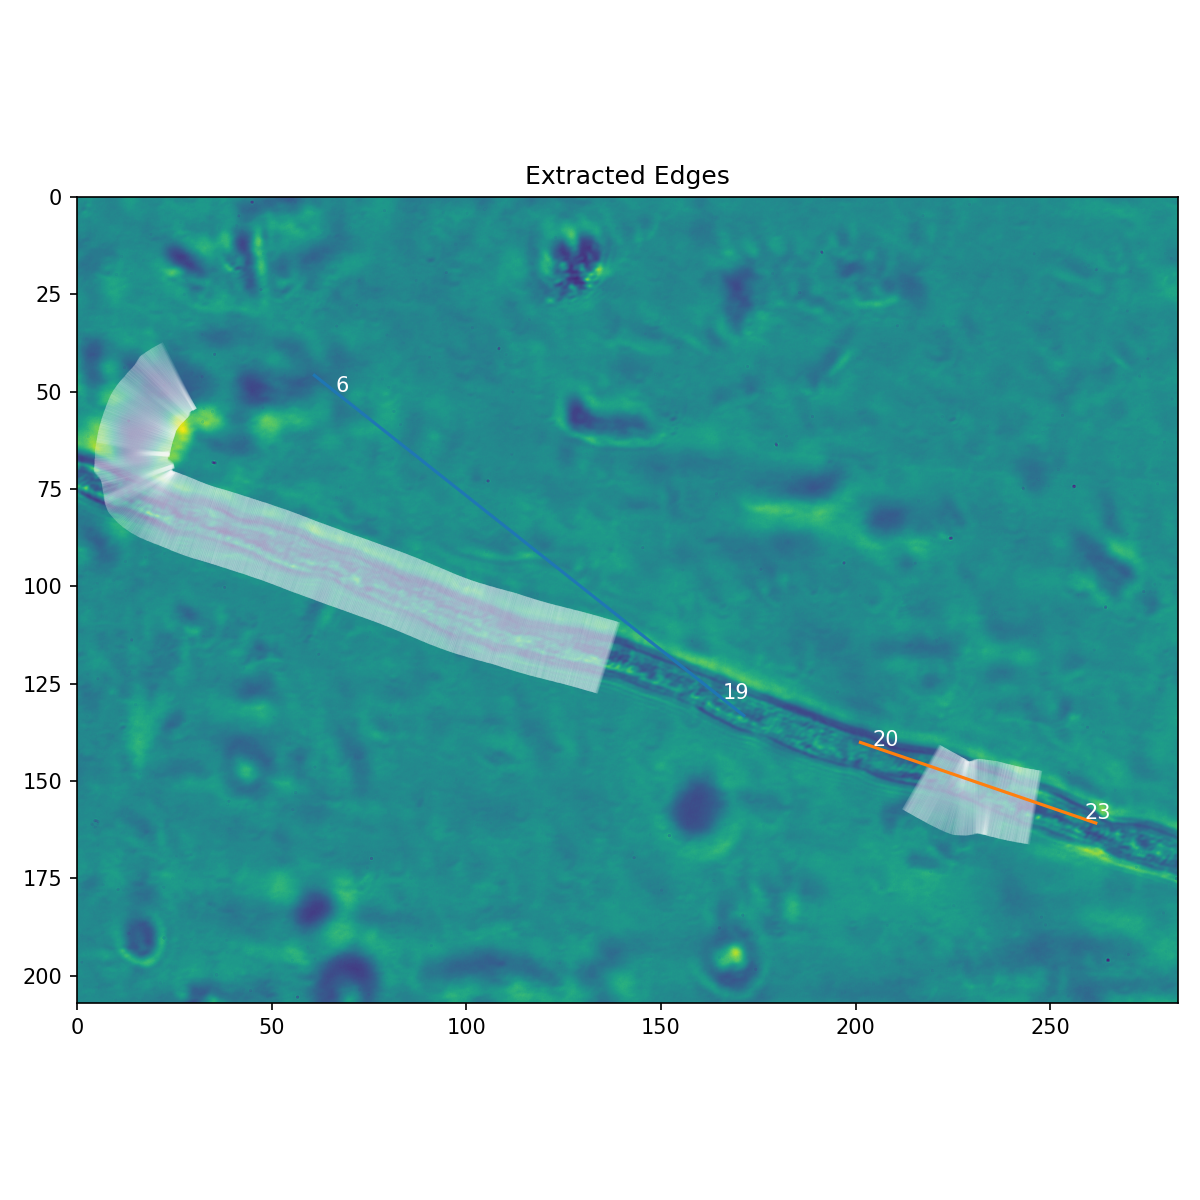

Saved the extracted edges
Saved an image of edge (19, 6)


  0%|          | 0/1 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [81]:
edges_objs = analysis_run(analysis_frame, analysis_folder, videos_folder, dropbox_address,
             logging=True,                 # Print progress to console
             kymo_normalize=True,                 
             kymo_section_width=2.6,       # Width of kymograph lines, adjusted for magnification
             edge_len_min=20,
             save_edge_extraction_plot=True,
             make_video=False,             # Make mp4 of raw data TIFFs
             create_snapshot=True,         # Save image of edge
             create_edge_video=False,      # Save video of edge
             photobleach_adjust=False,     # Adjust kymograph for photobleaching
             speed_ext_window_number=9,    # Size range to investigate speeds
             speed_ext_window_start = 3,   # Start size of window for GST
             speed_ext_c_thresh=0.95,      # Confidence threshold for speed determination
             speed_ext_c_falloff = 0.005,  # Confidence falloff as window size increases
             speed_ext_blur_size = 3,      # Kymograph blur Gaussian kernel size
             speed_ext_blur=True,          # Whether to preblur at all
             speed_ext_max_thresh = 80,    # Maximum expected speeds (in um/s)
             dropbox_upload=False          # Whether to upload results to dropbox
             )

In [87]:
plot_summary(edges_objs[0])

### Width profile Kymograph analysis
This is going to be some special code to extract multiple kymographs from the same edge, all next to each other. Requires running the previous code to get the analysis objects.

In [ ]:
print([[edge.edge_name for edge in edge_list] for edge_list in edges_objs])
edge_interest = edges_objs[0][2]

width_len = 8
#TODO: Get effective mean speed calculation in here too

kymos = edge_interest.extract_multi_kymo(width_len, target_length=90)
fourier_kymos = edge_interest.fourier_kymo()
speeds, times = edge_interest.extract_speeds(15)


In [ ]:
print(np.array(times).shape)
speed_max = 20
fig, ax = plt.subplots(width_len)
for i in range(width_len):
    ax[i].plot(times[i], np.nanmean(speeds[i][0], axis=1))
    ax[i].plot(times[i], np.nanmean(speeds[i][1], axis=1))
    ax[i].fill_between(times[i], np.nanmean(speeds[i][0], axis=1) + np.nanstd(speeds[i][0], axis=1), np.nanmean(speeds[i][0], axis=1) - np.nanstd(speeds[i][0],axis=1),alpha=0.5, facecolor='tab:blue')
    ax[i].fill_between(times[i], np.nanmean(speeds[i][1], axis=1) + np.nanstd(speeds[i][1], axis=1), np.nanmean(speeds[i][1], axis=1) - np.nanstd(speeds[i][1],axis=1),alpha=0.5, facecolor='tab:orange')
    ax[i].set_ylim((-speed_max, speed_max))

fig, ax = plt.subplots()
for i in range(width_len):
    ax.scatter(i, np.mean(np.nanmean(speeds[i][0], axis=1)[200:300]), c='tab:blue', label='to tip')
    ax.errorbar(i, np.mean(np.nanmean(speeds[i][0], axis=1)[200:300]), np.nanstd(speeds[i][0][200:300].flatten()), capsize=5, c='tab:blue')
    ax.scatter(i, np.mean(np.nanmean(speeds[i][1], axis=1)[200:300]), c='tab:orange', label='to root')
    ax.errorbar(i, np.mean(np.nanmean(speeds[i][1], axis=1)[200:300]), np.nanstd(speeds[i][1][200:300].flatten()), capsize=5, c='tab:orange')

# Module 3: Bulk Analysis
## First part: Assemble Edge DataFrame


In this initial part of the bulk analysis, all of the analysis folders will be looked through to find the edge data we're looking for. Additionally, there is an optional part to download the analysis folder back to the analysis folder we specified right at the top.

## Assuming all the analysis folders are already downloaded:
You can use below code to read the video_data.json files that are created during indexing of all the videos

In [88]:
folder_filter = dropbox_address[5:]

img_infos = glob.glob(f"{analysis_folder}{folder_filter}/**/video_data.json", recursive=True)
vid_anls_frame = pd.DataFrame()
for address in tqdm(img_infos):
    add_info = pd.read_json(address, orient='index').T
    vid_anls_frame = pd.concat([vid_anls_frame, add_info], ignore_index=True)

vid_frame = vid_anls_frame.sort_values('unique_id').reset_index(drop=True)


100%|██████████| 63/63 [00:00<00:00, 64.84it/s]


In [89]:
####################################################################################
### This is where you can apply the filters. Only those videos will be analyzed. ###
####################################################################################

analysis_frame = vid_frame[vid_frame['imaging_day'].le("20230726")].reset_index(drop=True)

####################################################################################
### Below code will prepare for those videos to be downloaded to videos_folder.  ###
####################################################################################
analysis_frame['plate_int'] = [entry.split('_')[-1] for entry in analysis_frame['plate_id']]
analysis_frame['video_int'] = [entry.split('_')[-1] for entry in analysis_frame['unique_id']]
analysis_frame

,imaging_day,storage_path,plate_id,root,strain,treatment,crossing_day,video_int,time_(s),mode,...,zpos,unique_id,folder,tot_path_drop,record_time,days_after_crossing,magnification,analysis_folder,videos_folder,plate_int
0,20230703,Dropbox\DATA\CocoTransport,20230703_Plate403,Carrot,C2,001P100N100C,20230626,001,30.0,BF,...,5.993,20230703_Plate403_001,CocoTransport/20230703_Plate403/001/Img,DATA/CocoTransport/20230703_Plate403/001/Img,16:45:29,7,50.0,E:/AMOLF_Data/analysis/CocoTransport/20230703_...,E:/AMOLF_Data/videos/CocoTransport/20230703_Pl...,Plate403
1,20230713,Dropbox\DATA\CocoTransport,20230713_Plate13,Carrot,O9,001P100N100C,20230713,001,60.0,BF,...,5.9,20230713_Plate013_001,CocoTransport/20230713_Plate013/001/Img,DATA/CocoTransport/20230713_Plate013/001/Img,12:07:45,0,50.0,E:/AMOLF_Data/analysis/CocoTransport/20230713_...,E:/AMOLF_Data/videos/CocoTransport/20230713_Pl...,Plate13
2,20230714,Dropbox\DATA\CocoTransport,20230714_Plate302,Carrot,A5,001P100N100C,20230714,002,30.0,BF,...,5.567,20230714_Plate302_002,CocoTransport/20230714_Plate302/002/Img,DATA/CocoTransport/20230714_Plate302/002/Img,11:50:33,0,50.0,E:/AMOLF_Data/analysis/CocoTransport/20230714_...,E:/AMOLF_Data/videos/CocoTransport/20230714_Pl...,Plate302
3,20230714,Dropbox\DATA\CocoTransport,20230714_Plate302,Carrot,A5,001P100N100C,20230714,003,30.0,BF,...,5.568,20230714_Plate302_003,CocoTransport/20230714_Plate302/003/Img,DATA/CocoTransport/20230714_Plate302/003/Img,11:51:33,0,50.0,E:/AMOLF_Data/analysis/CocoTransport/20230714_...,E:/AMOLF_Data/videos/CocoTransport/20230714_Pl...,Plate302
4,20230714,Dropbox\DATA\CocoTransport,20230714_Plate302,Carrot,A5,001P100N100C,20230714,004,30.0,BF,...,5.589,20230714_Plate302_004,CocoTransport/20230714_Plate302/004/Img,DATA/CocoTransport/20230714_Plate302/004/Img,11:52:38,0,50.0,E:/AMOLF_Data/analysis/CocoTransport/20230714_...,E:/AMOLF_Data/videos/CocoTransport/20230714_Pl...,Plate302
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58,20230718,Dropbox\DATA\CocoTransport,20230718_Plate431,Carrot,C2,001P100N100C,20230627,053,300.0,BF,...,6.19,20230718_Plate431_053,CocoTransport/20230718_Plate431/053/Img,DATA/CocoTransport/20230718_Plate431/053/Img,18:23:50,21,50.0,E:/AMOLF_Data/analysis/CocoTransport/20230718_...,E:/AMOLF_Data/videos/CocoTransport/20230718_Pl...,Plate431
59,20230718,Dropbox\DATA\CocoTransport,20230718_Plate431,Carrot,C2,001P100N100C,20230627,054,300.0,BF,...,6.199,20230718_Plate431_054,CocoTransport/20230718_Plate431/054/Img,DATA/CocoTransport/20230718_Plate431/054/Img,18:29:17,21,50.0,E:/AMOLF_Data/analysis/CocoTransport/20230718_...,E:/AMOLF_Data/videos/CocoTransport/20230718_Pl...,Plate431
60,20230718,Dropbox\DATA\CocoTransport,20230718_Plate431,Carrot,C2,001P100N100C,20230627,055,300.0,BF,...,6.356,20230718_Plate431_055,CocoTransport/20230718_Plate431/055/Img,DATA/CocoTransport/20230718_Plate431/055/Img,18:38:14,21,50.0,E:/AMOLF_Data/analysis/CocoTransport/20230718_...,E:/AMOLF_Data/videos/CocoTransport/20230718_Pl...,Plate431
61,20230718,Dropbox\DATA\CocoTransport,20230718_Plate431,Carrot,C2,001P100N100C,20230627,056,300.0,BF,...,6.356,20230718_Plate431_056,CocoTransport/20230718_Plate431/056/Img,DATA/CocoTransport/20230718_Plate431/056/Img,18:43:40,21,50.0,E:/AMOLF_Data/analysis/CocoTransport/20230718_...,E:/AMOLF_Data/videos/CocoTransport/20230718_Pl...,Plate431


In [90]:
data_obj = HighmagDataset(analysis_frame, analysis_folder, videos_folder)

Couldn't find the edges data file. Check analysis for 20230713_Plate013_001
Couldn't find the edges data file. Check analysis for 20230714_Plate302_002
Couldn't find the edges data file. Check analysis for 20230714_Plate302_004
Couldn't find the edges data file. Check analysis for 20230714_Plate302_005
Couldn't find the edges data file. Check analysis for 20230714_Plate302_006
Couldn't find the edges data file. Check analysis for 20230714_Plate302_007
Couldn't find the edges data file. Check analysis for 20230714_Plate302_009
Couldn't find the edges data file. Check analysis for 20230714_Plate302_010
Couldn't find the edges data file. Check analysis for 20230714_Plate302_011
Couldn't find the edges data file. Check analysis for 20230718_Plate431_001
Couldn't find the edges data file. Check analysis for 20230718_Plate431_002
Couldn't find the edges data file. Check analysis for 20230718_Plate431_003
Couldn't find the edges data file. Check analysis for 20230718_Plate431_004
Couldn't fin

In [91]:
plt.close('all')

###

### Example code binned violin-plot
bin-column represents the value to be binned, then multiple violin plots are graphed on the same axis.

C:\Users\night\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\linalg\linalg.py:2146: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)
C:\GitHub_Projects\AMOLF\amftrack\pipeline\development\high_mag_videos\high_mag_analysis.py:640: RuntimeWarning: Mean of empty slice
  violin_data_d.append(data)


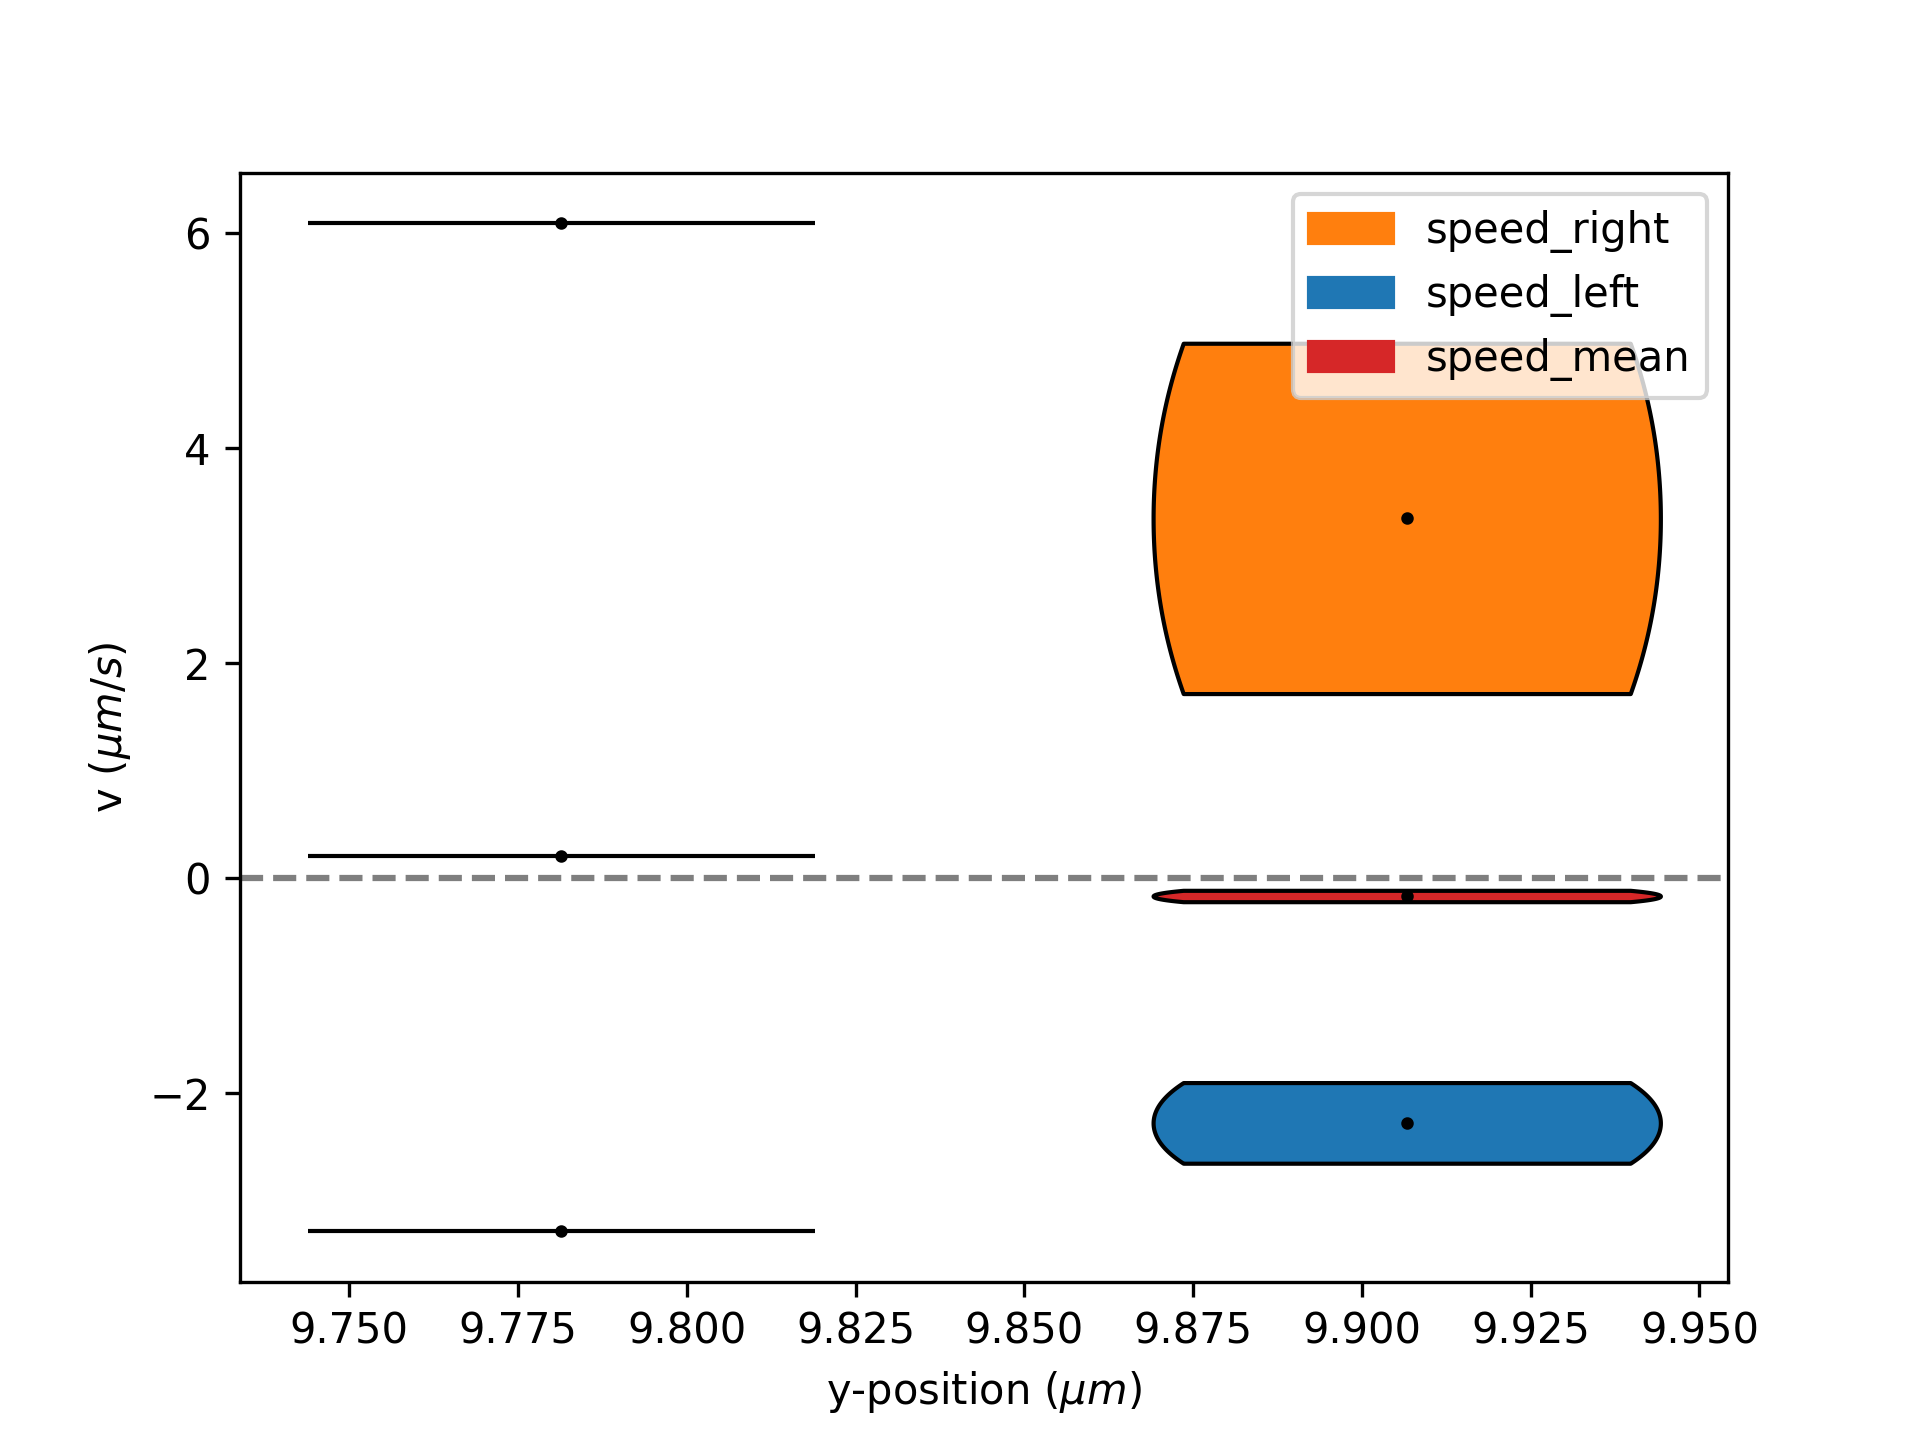

In [78]:
cover_filter_data = data_obj.filter_edges('coverage_tot', '>=', 0.5)
filter_BF = cover_filter_data.filter_edges('mode', '==', 'BF')
# filter_BF = cover_filter_data
bin_column = 'edge_width'

# bins = np.linspace(5, 15, 10)
bins = np.linspace(filter_BF.return_edge_frame()[bin_column].min(), filter_BF.return_edge_frame()[bin_column].max(), 7)
bin_series = filter_BF.bin_values(bin_column, bins)
# print(bin_series)

labels = []
fig, ax = filter_BF.plot_violins('speed_right', bins, c='tab:orange', labels=labels)
fig, ax = filter_BF.plot_violins('speed_left', bins, c='tab:blue', ax=ax, fig=fig, labels=labels)
fig, ax = filter_BF.plot_violins('speed_mean', bins, c='tab:red', ax=ax, fig=fig, labels=labels)

ax.axhline(c='black', alpha=0.5, linestyle='--')
ax.set_ylabel('v $(\mu m / s)$')
ax.set_xlabel('y-position $(\mu m)$')
ax.legend(*zip(*labels))



### Example code for bin-less violin plots
This can be for comparing videos, plates, anything with a unique ID

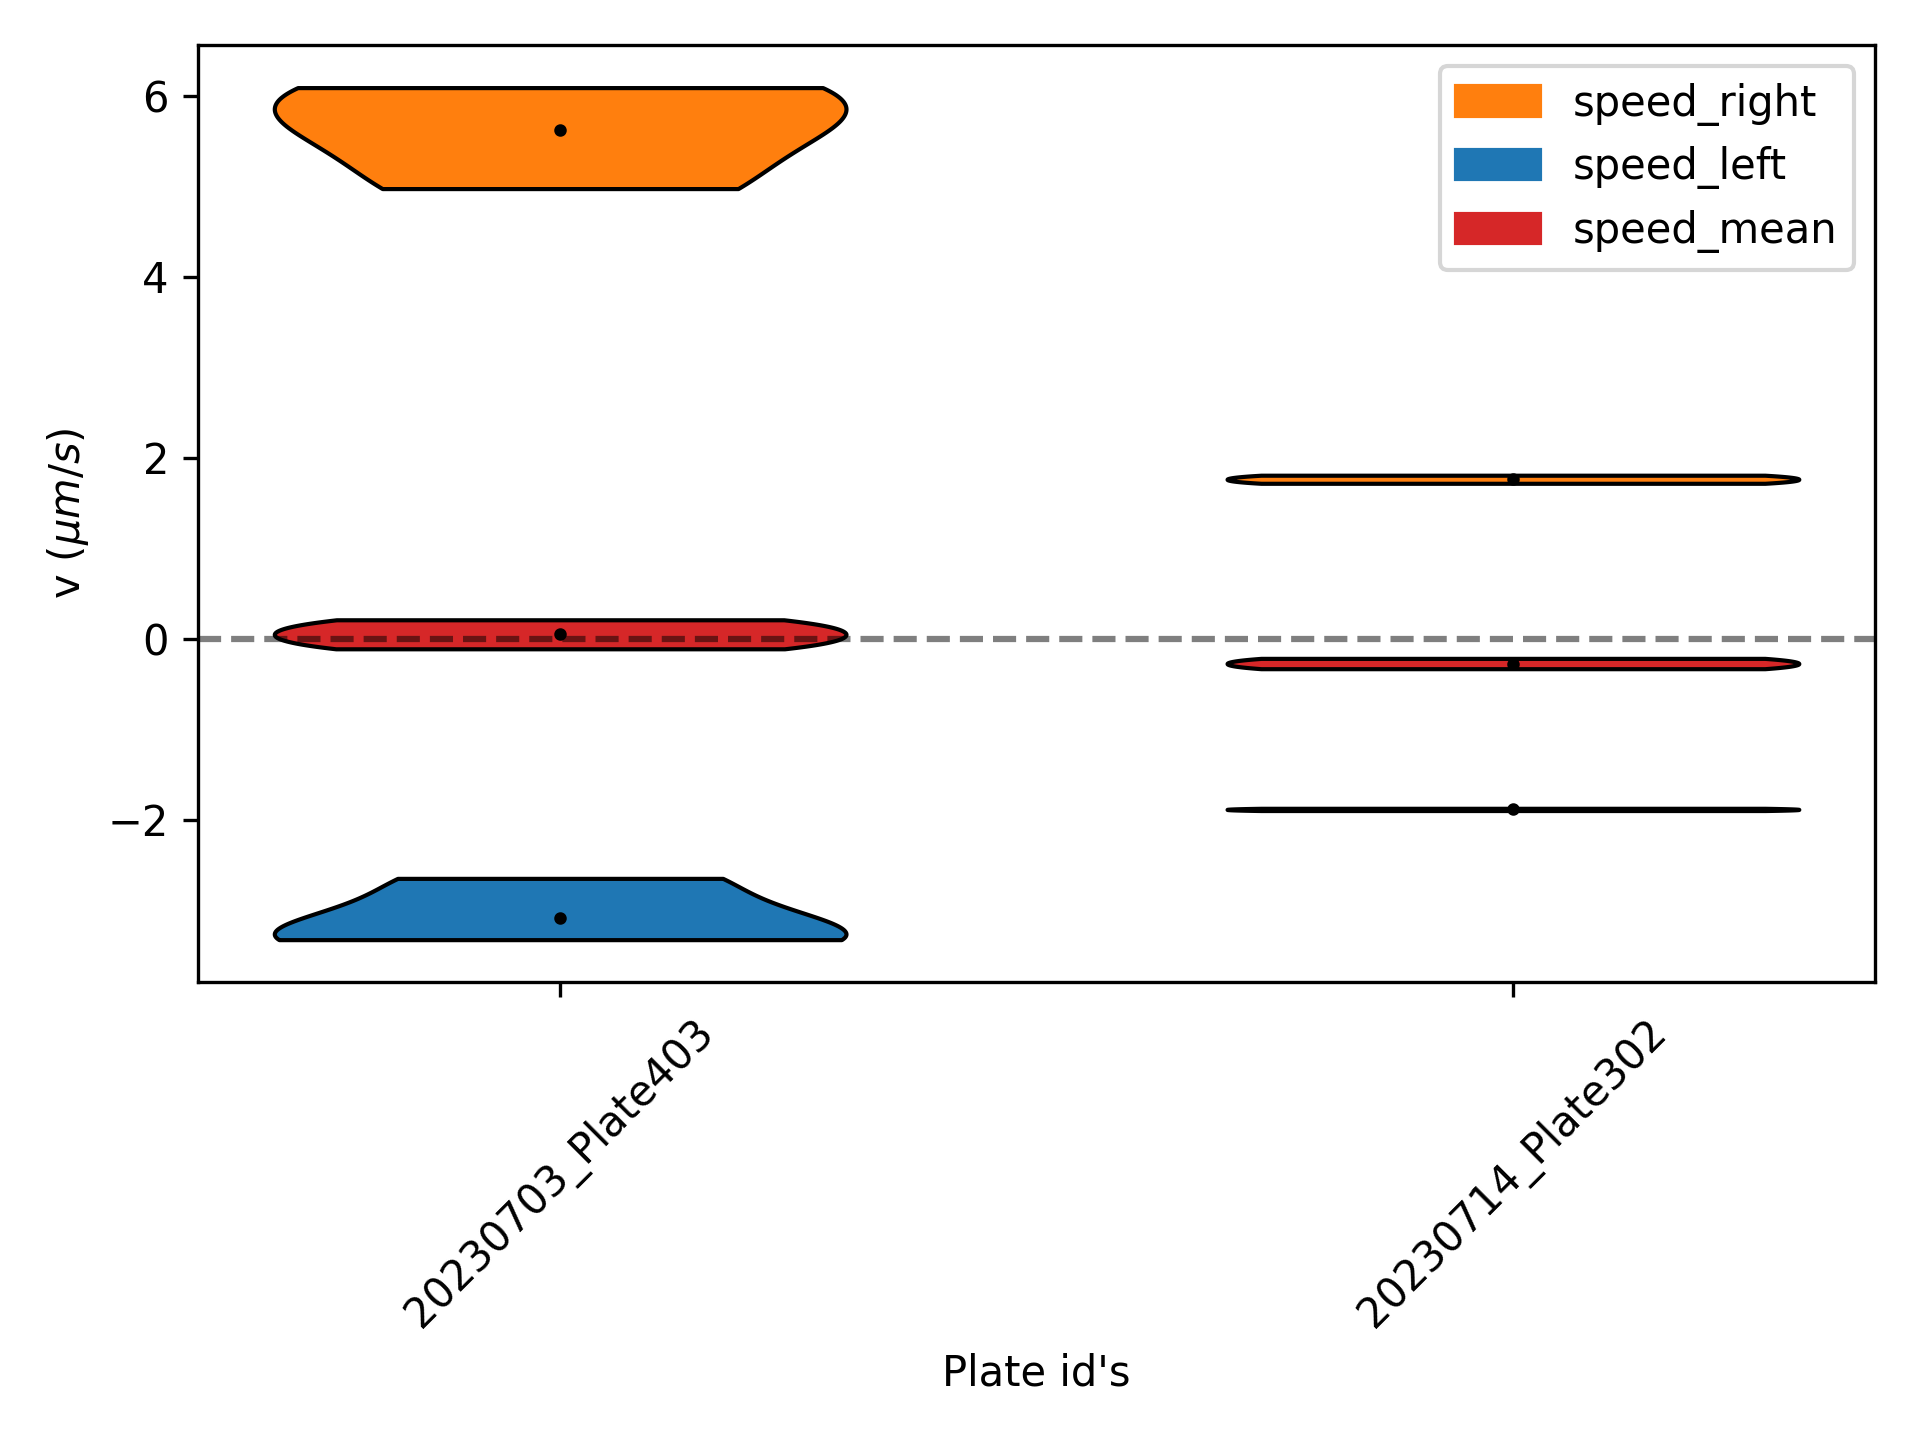

In [79]:
cover_filter_data = data_obj.filter_edges('coverage_tot', '>=', 0.3)
filter_BF = cover_filter_data

labels = []
fig, ax = filter_BF.plot_violins('speed_right', bin_separator='plate_id', c='tab:orange', labels=labels)
fig, ax = filter_BF.plot_violins('speed_left', bin_separator='plate_id', c='tab:blue', ax=ax, fig=fig, labels=labels)
fig, ax = filter_BF.plot_violins('speed_mean', bin_separator='plate_id', c='tab:red', ax=ax, fig=fig, labels=labels)

ax.axhline(c='black', alpha=0.5, linestyle='--')
ax.set_ylabel('v $(\mu m / s)$')
ax.set_xlabel('Plate id\'s')
ax.legend(*zip(*labels))
fig.tight_layout()

In [ ]:
print(data_obj.video_frame['video_int'].to_string())

### Example code on visualizing 4x/50x comparisons

In [ ]:
data_4x_filter = data_obj.filter_edges('magnification', '==', 4.0)
mag_corr_groups = [data_obj.context_4x(row) for index, row in data_4x_filter.video_frame.iterrows()]
for group in tqdm(mag_corr_groups):
    group.plot_4x_locs(analysis_folder)

### Example code for creating different plate maps
Below you can see the filtering options for different plates and the plot_plate_locs function that outputs a map with dots or arrows depending on your wishes. Current drawing modes are:
- 'scatter' for dots of the videos, separated by magnification
- 'speeds_mean' for black arrows denoting the effective mean speed of the flows
- 'speeds_both' for blue and orange arrows denoting the effective speed of flows in both directions
- 'vid_labels'  for a list of what videos were taken at each position

Index(['imaging_day', 'storage_path', 'plate_id', 'root', 'strain',
       'treatment', 'crossing_day', 'video_int', 'time_(s)', 'mode',
       'exposure_time_(us)', 'fps', 'binning', 'gain', 'gamma', 'Fiber Led',
       'xpos', 'ypos', 'zpos', 'unique_id', 'folder', 'tot_path_drop',
       'record_time', 'days_after_crossing', 'magnification',
       'analysis_folder', 'videos_folder', 'plate_int'],
      dtype='object')


  0%|          | 0/4 [00:00<?, ?it/s]


FileNotFoundError: [Errno 2] No such file or directory: 'E:\\AMOLF_Data\\analysis\\plot_outs/plate_20230703_Plate403_scatter.png'

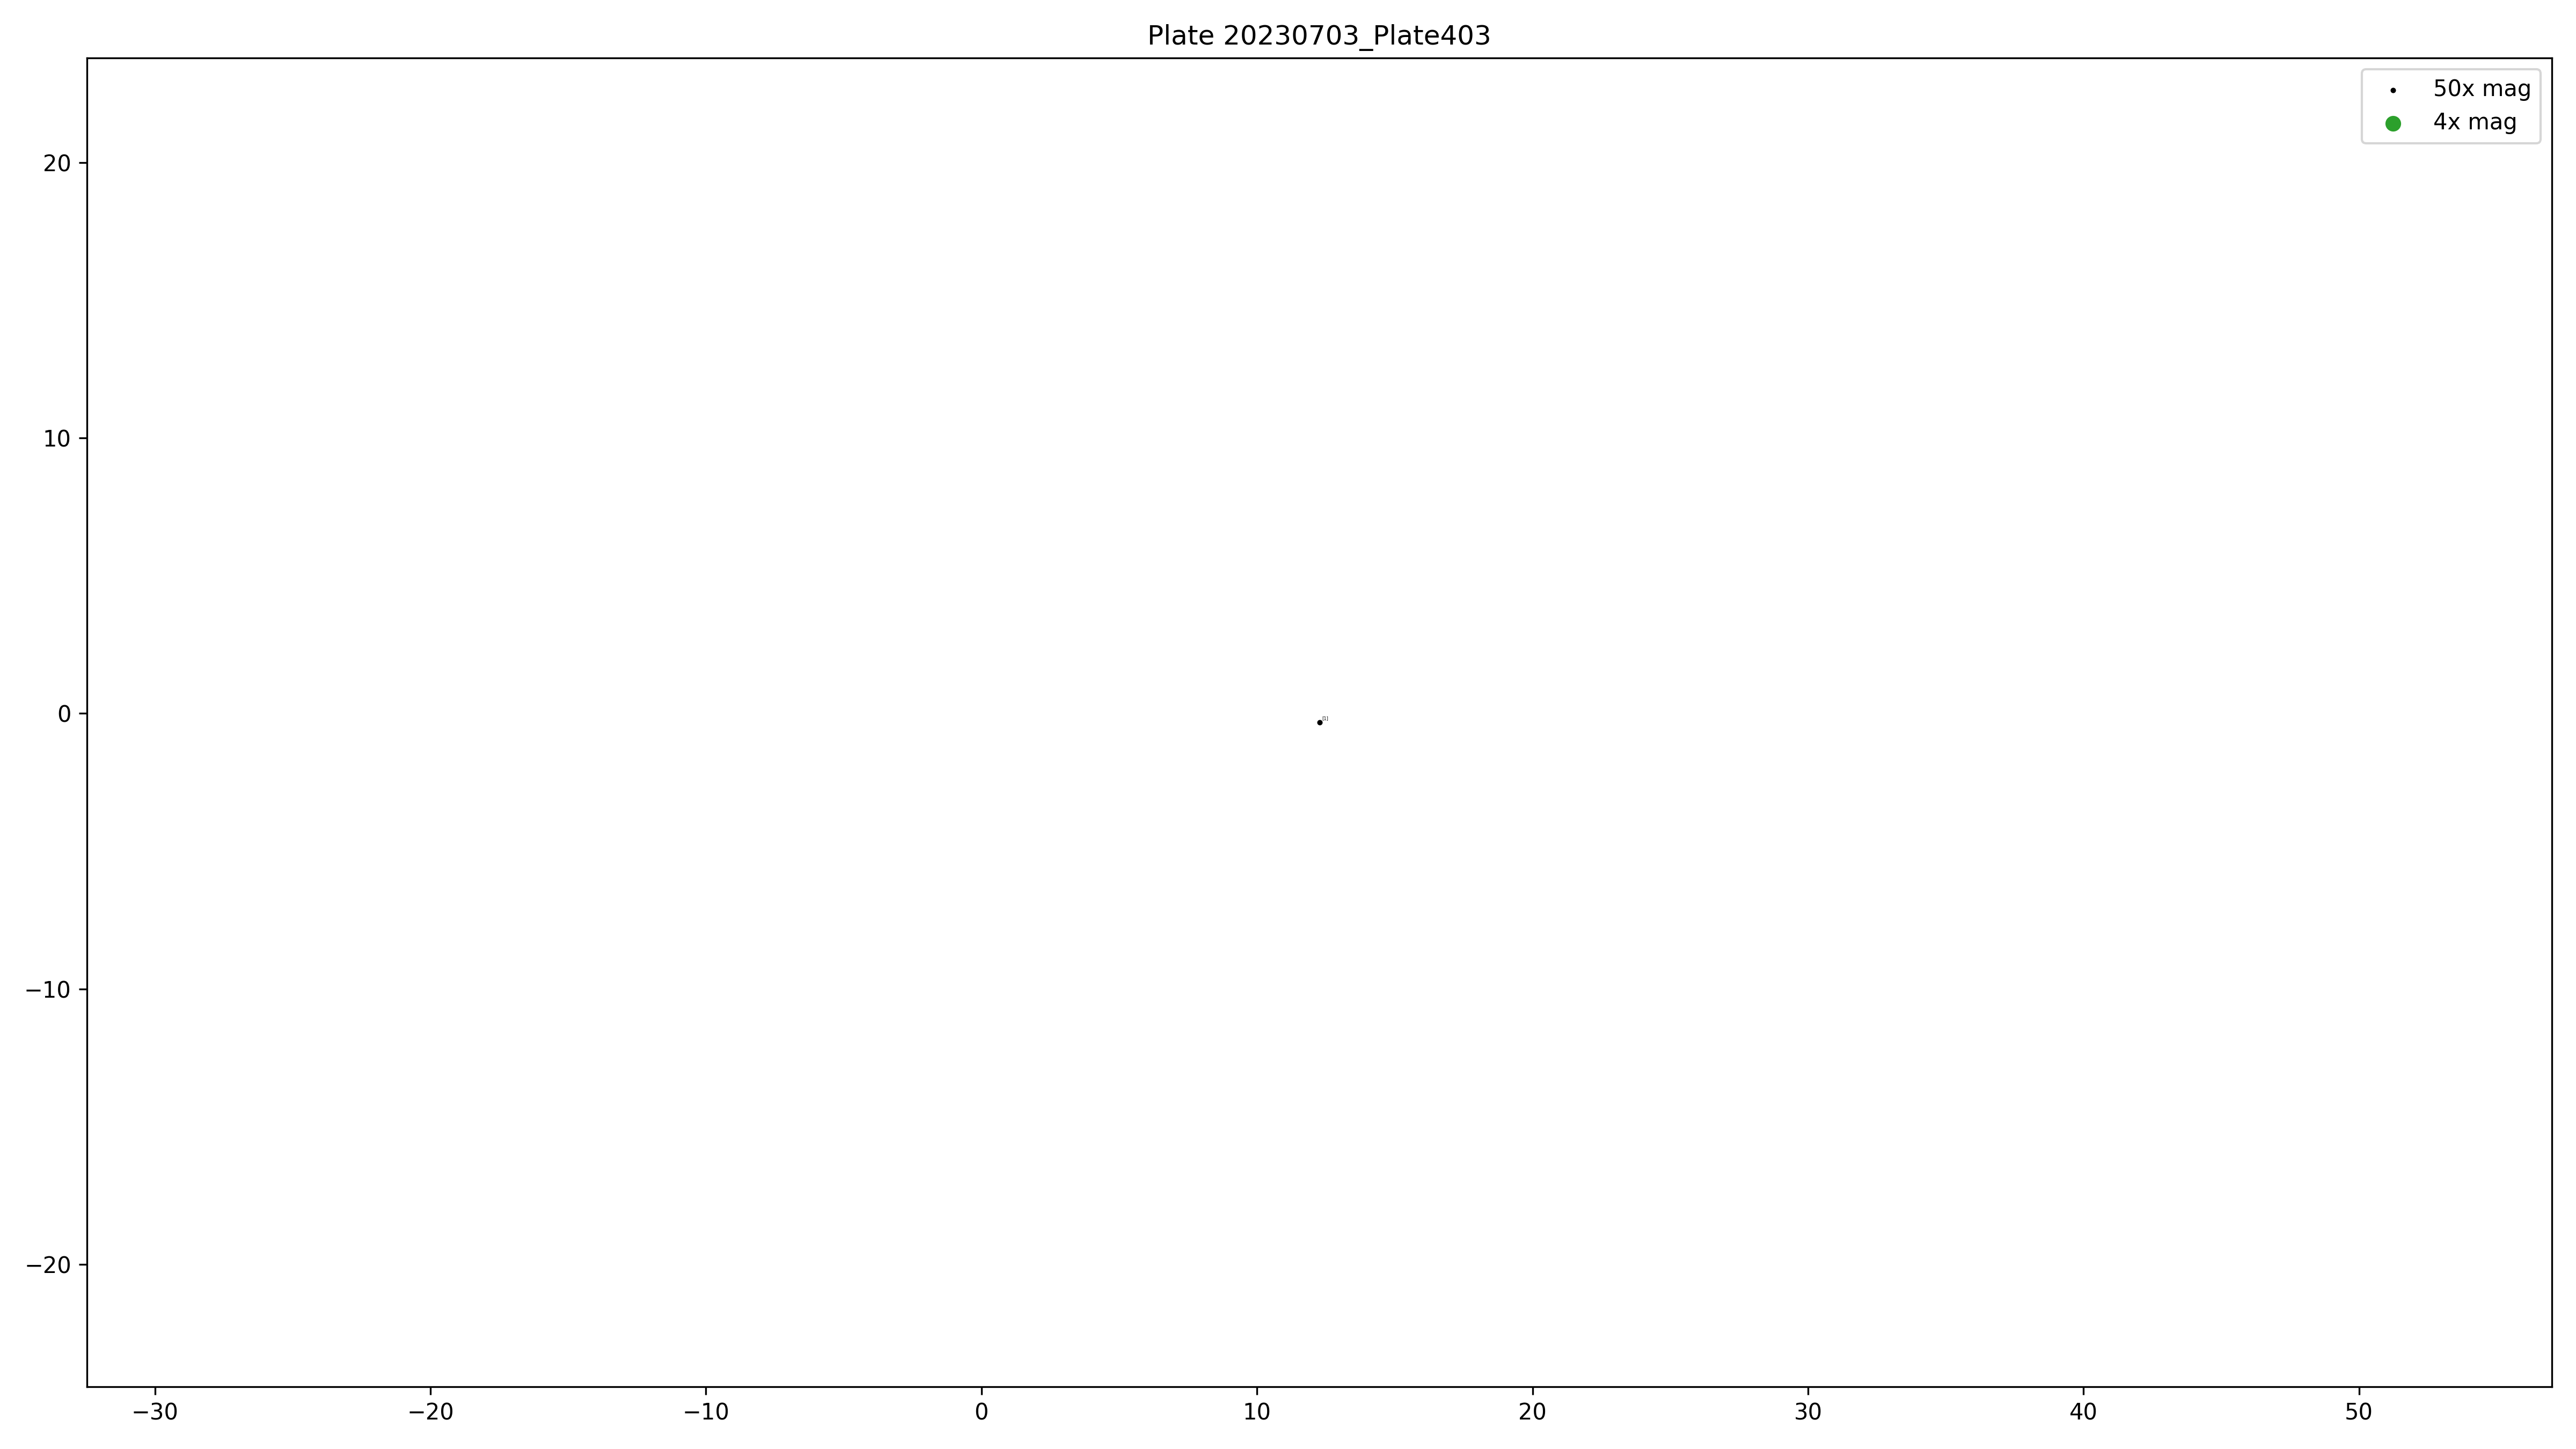

In [80]:
plt.close('all')
print(data_obj.video_frame.columns)

for plate_id in tqdm(data_obj.video_frame['plate_id'].unique()):
    plate_group = data_obj.filter_edges('coverage_tot', '>=', 0.3)
    plate_group = data_obj.filter_edges('plate_id', '==', plate_id)
    plate_group.plot_plate_locs(analysis_folder, spd_adj=2, modes=['scatter', 'vid_labels'])

In [ ]:
plt.close('all')

spd_maxes= []

print(data_obj.video_frame['plate_int'].unique())

linear_edges = data_obj.filter_edges('plate_int',  '==', 'Plate440')
linear_edges = linear_edges.filter_edges('coverage_left', '>=', 0.3)
linear_edges = linear_edges.filter_edges('coverage_right', '>=', 0.3)
# linear_edges = linear_edges.filter_edges('speed_left_std', '<=', 0.5)
# linear_edges = linear_edges.filter_edges('speed_right_std', '<=', 0.5)
# linear_edges = linear_edges.filter_edges('speed_left', '<=', -0.9)
# linear_edges = linear_edges.filter_edges('speed_right', '>=', 0.9)
for edge in tqdm(linear_edges.edge_objs):
    spd_maxes.append(edge.plot_speed_histo(spd_extent=10, spd_tiff_lowbound=0.5, spd_cutoff = 0.5, bin_res=1000, plot_fig=False))
    
    

In [ ]:
print(linear_edges.edges_frame['video_int'].to_string())

In [ ]:
spd_maxes = np.array(spd_maxes)
fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(linear_edges.edges_frame['ypos'].astype(float)[59:75], spd_maxes.T[0][59:75], label='to tip, day 1')
ax.scatter(linear_edges.edges_frame['ypos'].astype(float)[59:75], spd_maxes.T[1][59:75], label='to root, day 1')
ax.scatter(linear_edges.edges_frame['ypos'].astype(float)[148:178], spd_maxes.T[0][148:178], label='to tip, day 2')
ax.scatter(linear_edges.edges_frame['ypos'].astype(float)[148:178], spd_maxes.T[1][148:178], label='to root, day 2')
# ax.scatter(linear_edges.edges_frame['ypos'].astype(float)[87:93], spd_maxes.T[0][87:93], label='to tip, hypha 3')
# ax.scatter(linear_edges.edges_frame['ypos'].astype(float)[87:93], spd_maxes.T[1][87:93], label='to root, hypha 3')
# ax.scatter(linear_edges.edges_frame['ypos'].astype(float)[93:], spd_maxes.T[0][93:], label='to tip, hypha 4')
# ax.scatter(linear_edges.edges_frame['ypos'].astype(float)[93:], spd_maxes.T[1][93:], label='to root, hypha 4')
# ax.scatter(linear_edges.edges_frame['ypos'].astype(int), spd_maxes.T[0], label='to tip')
# ax.scatter(linear_edges.edges_frame['ypos'].astype(int), spd_maxes.T[1], label='to root')
ax.grid(True)
ax.set_ylabel("Measured speed (max of histogram) $(\mu m /s)$")
ax.set_xlabel("y-position (root to tip)")
ax.set_title("Speeds along a single hypha")
ax.legend()
# print(linear_edges.edges_frame['video_int'].to_string())